# An Introduction to Qiskit Nature
<br/>
<br/>
<br/>
<br/>
<br/>
Max Rossmannek<br/>
IBM Quantum, IBM Research Europe - Zürich

Qiskit Nature is the application module dealing with problems in **natural sciences**.
Its goal is to provide end-user oriented modules which enable the fast solution of problems in _chemistry_, _physics_ and _biology_.

Chemistry problems are of particular interest because they are a natural simulation target for quantum computing.

<div style="float: left; width: 50%;">
    <br/>
    <br/>
    <i>"If you have 125 orbitals and you want to store all possible configurations, then you need more memory in your classical computer than there are atoms in the universe."</i>
    <br/>
    <br/>
    Matthias Troyer
    
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/intro.png" width="600"/>
    <br>
</div>

Nature currently provides the following modules:

<img src="images/overview.png" width="1400"/>

In general, any application is split into **Problems** and **Solvers** which are combined like so:
<img src="images/Nature_YT_Workflow.svg"/>
> or in terms of code: `result = solver.solve(problem)`

This modular approach permits the reusability of a solver for multiple problems.

Depending on your actual application, the internals of your problem can take different forms.
For example, the `ElectronicStructureProblem` (which we will be discussing today) looks like this:
<img src="images/Nature_YT_ElectronicStructureProblem.svg"/>

A similar modularity exists for the solvers. Generally these are provided by the `qiskit_nature.algorihtms` module which provide convenient wrappers of the actual algorithms implement in Qiskit Terra.
Here is an example of the `GroundStateEigensolver` which we will be looking at today:
<img src="images/Nature_YT_GroundStateEigensolver.svg"/>

## Electronic Structure

Let us now dive into the `ElectronicStructureProblem`. First, to cover some basics, let us talk about the general electronic Hamiltonian,

<img src="images/hamiltonian.png" width="1600"/>

Here, we made use of the _Born-Oppenheimer approximation_, which allows us to separate the motion of the electrons from that of the much heavier nuclei.

Finally, the format expression of our problem is given by the _non-relativistic time-independent Schrödinger equation_:

$$
\hat{H} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle,
$$

whose ground state energy is given by:
$$
E_0 = \frac{\langle \Psi_0 | \hat{H} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}
$$
where $\Psi_0$ is the ground state of the system.

### Second Quantization

Up until now we have used the so-called _first quantization_ notation. However, in Qiskit we more commonly express our problems in the _second quantization_ form.
This notation allows us to write our Hamiltonian as a weighted sum of **creation** and **annihilation** operator products.

Our Hamiltonian takes the form:

$$
\hat{H}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q + 
\frac{1}{2} \sum_{pqrs} g_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s
$$
with the 1-body integrals
$$
h_{pq} = \int \phi^*_p(r) \left( -\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{R_I- r} \right)   \phi_q(r)dr
$$
and 2-body integrals
$$
g_{pqrs} = \int \frac{\phi^*_p(r_1)  \phi^*_q(r_2) \phi_r(r_2)  \phi_s(r_1)}{|r_1-r_2|}dr_1dr_2.
$$

The beauty of the second quantization formalism is that not only operators but also **states** are written using the _creation_ and _annihilation_ operators.

<div style="float: left; width: 50%;">
    Effectively, this means that our system's wave function can be represented as an <b>occupation number vector</b>.
    This enables a very straight forward notation of <i>ground</i> and <i>excited states</i>:
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/onv.png" width="600"/>
    <br>
</div>

### The `ElectronicStructureProblem`

In [1]:
import warnings
from h5py.h5py_warnings import H5pyDeprecationWarning
warnings.filterwarnings(action="ignore", category=H5pyDeprecationWarning)

The `ElectronicStructureProblem` makes it easy for us to represent a problem of the form which we just discussed.
As an input, this kind of problem takes a so called `Driver` which is a concept in Qiskit Nature that allows us to couple to other (classical) computational chemistry codes which compute the 1- and 2-body integrals ($h_{pq}$ and $g_{pqrs}$) for us.

As a simple example, we will be using the generic `Molecule`-based interface and tell it to use `PySCF` as the classical computational backend.

In [2]:
from qiskit_nature.drivers import Molecule

molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.115]],
        ["H", [0.0, 0.754, -0.459]],
        ["H", [0.0, -0.754, -0.459]],
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

In [3]:
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

We could now run the driver manually by calling `driver.run()` but the preferred way is to wrap it into the previously mentioned `ElectronicStructureProblem` which we can solve later on.

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver)

Out of curiosity let us inspect the Hamiltonian of our system in its second-quantized form:

In [5]:
# this will call driver.run() internally
second_q_ops = problem.second_q_ops()

In [6]:
from qiskit_nature.operators.second_quantization import FermionicOp

# we increase the truncation value of the FermionicOp applied while printing
FermionicOp.set_truncation(500)

In [7]:
hamiltonian = second_q_ops[0]
print(hamiltonian)

Fermionic Operator
register length=14, number terms=1085
  (0.009448189516231487+0j) * ( +_0 +_1 -_2 -_6 )
+ (-0.0016037622713060834+0j) * ( +_0 +_1 -_3 -_5 )
+ (-0.030824961500492448+0j) * ( +_0 -_1 +_2 -_6 )
+ (0.021376771984260974+0j) * ( +_0 -_1 -_2 +_6 )
+ (0.02231515563955718+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.020711393368251115+0j) * ( +_0 -_1 -_3 +_5 )
+ (0.05804237323821828+0j) * ( +_0 -_1 +_7 -_8 )
+ (0.022361153748978534+0j) * ( +_0 -_1 +_7 -_10 )
+ (0.03626704869816795+0j) * ( +_0 -_1 +_7 -_12 )
+ (-0.05804237323821834+0j) * ( +_0 -_1 -_7 ...


We can gain further insight by investigating the raw output of our driver:

In [8]:
print(problem.grouped_property)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=O 0.0 0.0 0.115;H 0.0 0.754 -0.459;H 0.0 -0.754 -0.459
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9941038468519986
		[0, 1] = -0.23249684427278736
		[0, 2] = 2.167773289148554e-16
		[0, 3] = -0.10305188327114538
		[0, 4] = -1.1184279055969602e-16
		[0, 5] = -0.1341581577989696
		[0, 6] = -1.4618696113974377e-16
		[1, 0] = 0.026782078656149268
		[1, 1] = 0.8301922072362835
		[1, 2] = -1.0806837643609834e-15
		[1, 3] = 0.5369920122052786
		[1, 4] = 5.221554651560267e-16
		[1, 5] = 0.9038656248714154
		[1, 6] = 1.0711094741209037e-15
		[2, 0] = -1.327163444823544e-19
		[2, 1] = -1.0526439891670716e-18
		[2, 2] = -4.804794052085618e-16
		[2, 3] = -1.221566280389757e-15
		[2, 4] = 

<div style="float: left; width: 50%;">
    We can reduce the size of our problem by selected a subset of orbitals to be treated with the quantum algorithm. This concept is known as an <b>active space</b>.
</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/active_space.png" width="600"/>
</div>

Qiskit Nature provides the generic `ActiveSpaceTransformer` to apply such a reduction:

In [9]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_molecular_orbitals=3,
)

In [10]:
problem_reduced = ElectronicStructureProblem(driver, [transformer])
second_q_ops_reduced = problem_reduced.second_q_ops()
hamiltonian_reduced = second_q_ops_reduced[0]

In [11]:
print(hamiltonian_reduced)

Fermionic Operator
register length=6, number terms=33
  (0.03893103043276064+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.038931030432760624+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.024354547060211944+0j) * ( +_0 -_2 +_3 -_5 )
+ (-0.024354547060211937+0j) * ( +_0 -_2 -_3 +_5 )
+ (-0.038931030432760624+0j) * ( -_0 +_1 +_3 -_4 )
+ (0.038931030432760604+0j) * ( -_0 +_1 -_3 +_4 )
+ (-0.024354547060211937+0j) * ( -_0 +_2 +_3 -_5 )
+ (0.024354547060211923+0j) * ( -_0 +_2 -_3 +_5 )
+ (0.11590317383979426+0j) * ( +_1 -_2 +_4 -_5 )
+ (-0.11590317383979416+0j) * ( +_1 -_2 -_4  ...


In [12]:
print(problem_reduced.grouped_property_transformed)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=O 0.0 0.0 0.115;H 0.0 0.754 -0.459;H 0.0 -0.754 -0.459
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9941038468519986
		[0, 1] = -0.23249684427278736
		[0, 2] = 2.167773289148554e-16
		[0, 3] = -0.10305188327114538
		[0, 4] = -1.1184279055969602e-16
		[0, 5] = -0.1341581577989696
		[0, 6] = -1.4618696113974377e-16
		[1, 0] = 0.026782078656149268
		[1, 1] = 0.8301922072362835
		[1, 2] = -1.0806837643609834e-15
		[1, 3] = 0.5369920122052786
		[1, 4] = 5.221554651560267e-16
		[1, 5] = 0.9038656248714154
		[1, 6] = 1.0711094741209037e-15
		[2, 0] = -1.327163444823544e-19
		[2, 1] = -1.0526439891670716e-18
		[2, 2] = -4.804794052085618e-16
		[2, 3] = -1.221566280389757e-15
		[2, 4] = 

## Mapping the Problem to the Qubit Space

### Molecular Orbitals

<div style="float: left; width: 50%;">
    We sneakily introduced the concept of <b>molecular orbitals</b> which are obtained from the <i>atomic orbitals</i> via a unitary transformation. In other words: each molecular orbital is a linear combination of all atomic orbitals.
    <br/>
    <br/>
    The choice of <b>basis set</b> (<span>sto3g</span> in our example thus far) directly affects the number of orbitals.
    As a rule of thumb, choosing a larger basis will include more diffuse atomic orbitals.
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/water_mo_diagram.jpg" width="600"/>
    <br>
</div>


In order to solve our problem with a Quantum algorithm we must map our second-quantized Hamiltonian into a qubit operator. This is done with the `QubitConverter` in combination with a `QubitMapper` of your choice.

Each MO can hold up to two electrons, one spin-up (_alpha_) and one spin-down (_beta_) electron.

In Qiskit we will need to map these two cases onto the quantum computer separately. Thus, we are working with **spin orbitals** which are identical to the MOs but restrict the spin in either the up or down configuration, depending on the nature of the orbital.

The most straight forward mapping is the *Jordan-Wigner* one which stores the *occupation* information of one spin orbital in one qubit:

<img src="images/jw_mapping.png" width="1400"/>

In [13]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

jw_mapper = JordanWignerMapper()
jw_converter = QubitConverter(jw_mapper)

In [14]:
qubit_op_jw = jw_converter.convert(hamiltonian_reduced)
print(qubit_op_jw)

0.009732757608190156 * IYYIYY
+ 0.009732757608190156 * IXXIYY
+ 0.009732757608190156 * IYYIXX
+ 0.009732757608190156 * IXXIXX
+ 0.006088636765052984 * YZYYZY
+ 0.006088636765052984 * XZXYZY
+ 0.006088636765052984 * YZYXZX
+ 0.006088636765052984 * XZXXZX
+ 0.028975793459948544 * YYIYYI
+ 0.028975793459948544 * XXIYYI
+ 0.028975793459948544 * YYIXXI
+ 0.028975793459948544 * XXIXXI
- 0.05135743132371634 * IIIIII
- 0.48094051547759054 * ZIIIII
- 0.425857234108475 * IZIIII
+ 0.11275928505376268 * ZZIIII
- 0.1762859123911116 * IIZIII
+ 0.15056813358931842 * ZIZIII
+ 0.13748636180405815 * IZZIII
- 0.48094051547759065 * IIIZII
+ 0.15537730842446174 * ZIIZII
+ 0.1417350785137112 * IZIZII
+ 0.15665677035437142 * IIZZII
- 0.4258572341084751 * IIIIZI
+ 0.1417350785137112 * ZIIIZI
+ 0.14925817605490688 * IZIIZI
+ 0.1472191194122483 * IIZIZI
+ 0.11275928505376268 * IIIZZI
- 0.17628591239111135 * IIIIIZ
+ 0.15665677035437142 * ZIIIIZ
+ 0.1472191194122483 * IZIIIZ
+ 0.22003977334376132 * IIZIIZ
+ 0.15

In this step we can reduce the size of our problem further by leveraging symmetries in the Hilbert space of our system. One mapping which supports a straight-forward removal of 2 qubits by exploiting the particle-conserving properties of electronic structure problems, is the *parity* mapping:

In [15]:
from qiskit_nature.mappers.second_quantization import ParityMapper

parity_mapper = ParityMapper()
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)

In [16]:
qubit_op_parity = parity_converter.convert(hamiltonian_reduced, num_particles=problem_reduced.num_particles)
print(qubit_op_parity)

-0.009732757608190153 * ZXZX
- 0.009732757608190153 * IXZX
+ 0.009732757608190153 * ZXIX
+ 0.009732757608190153 * IXIX
+ 0.0060886367650529825 * XXXX
- 0.0060886367650529825 * YYXX
- 0.0060886367650529825 * XXYY
+ 0.0060886367650529825 * YYYY
- 0.028975793459948534 * XZXZ
+ 0.028975793459948534 * XIXZ
- 0.028975793459948534 * XZXI
+ 0.028975793459948534 * XIXI
- 0.05135743132371632 * IIII
- 0.6184268772816486 * ZIII
- 0.5764253676977933 * ZZII
+ 0.2890451974448742 * IZII
+ 0.6184268772816487 * IIZI
- 0.15537730842446168 * ZIZI
- 0.14173507851371114 * ZZZI
+ 0.15665677035437137 * IZZI
- 0.5764253676977933 * IIZZ
+ 0.14173507851371114 * ZIZZ
+ 0.14925817605490682 * ZZZZ
- 0.14721911941224824 * IZZZ
- 0.28904519744487395 * IIIZ
+ 0.15665677035437137 * ZIIZ
+ 0.14721911941224824 * ZZIZ
- 0.22003977334376126 * IZIZ


## Finding the Ground-State Solution

<div style="float: left; width: 50%;">
Now that we have converted our problem to a Qubit operator, we need to find it's eigenvalue which corresponds to the ground state of our system.
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/H2_gs.png" width="400"/>
    <br>
</div>

**The Variational Quantum Eigensolver (VQE)**

<img src="images/vqe.png" width="1500"/>

The simplest way of constructing a `VQE` with a given backend is to use a _factory_ class as provided by Qiskit Nature:

In [17]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCFactory

vqe_factory = VQEUCCFactory(
    quantum_instance=StatevectorSimulator(),
    #quantum_instance=QasmSimulator(),
    optimizer=SLSQP(),
)

Besides the simpler interface, the factory also allows us to _postpone_ the construction of our wavefunction-Ansatz until it is absolutely necessary. This is important, because particle-conserving Ansätze (like the `UCC` Ansatz used here) require the number of particles of our system as an input.
This may not be available early on in the stack which is why this factory is so powerful.

This factory can then be used to construct a `GroundStateEigensolver` with which we can finally solve our problem:

In [18]:
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

solver = GroundStateEigensolver(parity_converter, vqe_factory)

In [19]:
result = solver.solve(problem_reduced)

In [20]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.248285546105
  - computed part:      -1.664149612417
  - ActiveSpaceTransformer extracted energy part: -82.584135933688
~ Nuclear repulsion energy (Hartree): 9.285714221678
> Total ground state energy (Hartree): -74.962571324427
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00377945]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.68311968]
    - computed part:      [0.0  0.0  0.43252811]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.25059156]
  > Dipole moment (a.u.): [0.0  0.0  -0.67934023]  Total: 0.67934023
                 (debye): [0.0  0.00000001  -1.72671046]  Total: 1.72671046
 


### VQE Runtime

The newly introduced **Runtime** greatly reduces the waiting time associated with running quantum algorithms on real hardware devices. It does so by (among other things) executing the classical parts of a hybrid quantum-classical algorithm on an IBM server closely located to the actual device, thereby minimizing communication overhead.

<div style="float: left; width: 50%;">
    <b>Before:</b>
    <img src="images/runtime_1.png" width="800"/>
    <b>Now:</b>
    <img src="images/runtime_2.png" width="800"/>
</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <br/>
    <br/>
    <br/>
    <br/>
    <img src="images/runtime_3.png" width="800"/>
</div>

In [21]:
from urllib3.connection import SystemTimeWarning
warnings.filterwarnings(action="ignore", category=SystemTimeWarning)

In [22]:
import numpy as np

np.random.seed(42)

First, we construct a new Ansatz manually:

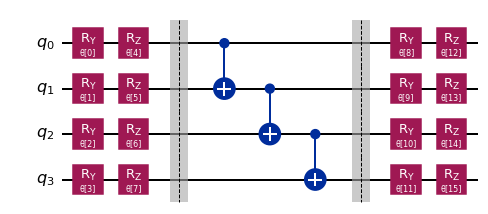

In [23]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=qubit_op_parity.num_qubits, reps=1, entanglement='linear', insert_barriers=True)
ansatz.decompose().draw('mpl', style='iqx')

The reason for constructing an Ansatz manually is two-fold:
1. To show you how this is done, too.
2. Writing a custom Factory for constructing a `VQEProgram` causes unnecessary overhead for this tutorial.

Now we can load our IBMQ account, the provider and select a backend which has runtime-support:

In [24]:
from qiskit.providers.ibmq import IBMQ, IBMQAccountError

try:
    IBMQ.load_account()
    provider = IBMQ.get_provider(group="open")
except IBMQAccountError:
    print("No IBMQ account credentials available")
    provider = None
else:
    print("Provider supports runtime: ", provider.has_service("runtime"))

    backend = provider.get_backend("ibmq_qasm_simulator")

Provider supports runtime:  True


And finally we can construct a new VQE solver using `VQEClient`:

In [25]:
from qiskit_nature.runtime import VQEClient

optimizer = {
    "name": "SPSA",
    "maxiter": 50,
}
initial_point = np.random.random(ansatz.num_parameters)

if provider is not None:
    runtime_vqe = VQEClient(
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=initial_point,
        provider=provider,
        backend=backend,
        shots=1024,
        measurement_error_mitigation=True,
    )

In [26]:
if provider is not None:
    runtime_vqe_solver = GroundStateEigensolver(parity_converter, runtime_vqe)

In [27]:
if provider is not None:
    runtime_result = runtime_vqe_solver.solve(problem_reduced)

In [28]:
if provider is not None:
    print(runtime_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.041164244605
  - computed part:      -1.457028310917
  - ActiveSpaceTransformer extracted energy part: -82.584135933688
~ Nuclear repulsion energy (Hartree): 9.285714221678
> Total ground state energy (Hartree): -74.755450022928
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.320 S: 0.491 S^2: 0.732 M: -0.023
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00377945]
 
  0: 
  * Electronic dipole moment (a.u.): [0.04794037  0.51204445  -0.86692576]
    - computed part:      [0.04794037  0.51204445  -1.11751732]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.25059156]
  > Dipole moment (a.u.): [-0.04794037  -0.51204445  0.87070521]  Total: 1.01124446
                 (debye): [-0.12185225  -1.30148706  2.21311168]  Total: 2.5703268
 


## Summary

<img src="images/summary.png" width="1400"/>

## Additional Resources

* Documentation: https://qiskit.org/documentation/nature/
* Tutorials: https://qiskit.org/documentation/nature/tutorials/index.html
* Source code: https://github.com/Qiskit/qiskit-nature

In [29]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright